In [33]:
"""
Read and split ogb and planetoid datasets
"""

import os, sys
import time
sys.path.insert(0, '..')
import torch
from torch.utils.data import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import (add_self_loops, negative_sampling,
                                   to_undirected)

from torch_geometric.loader import DataLoader as pygDataLoader
import wandb
from src.utils import ROOT_DIR, get_same_source_negs
from src.data import get_ogb_data

# Cora

In [34]:
dataset_name = 'cora'
path = os.path.join(ROOT_DIR, 'dataset', dataset_name)
dataset = Planetoid(path, dataset_name)

In [35]:
dataset.data

/home/kit/aifb/cc7738/anaconda3/envs/ss/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [36]:
dataset.data.x.shape

torch.Size([2708, 1433])

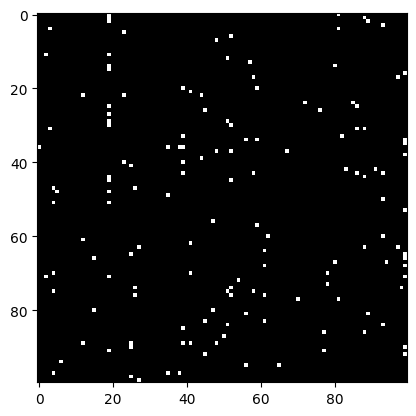

In [37]:
import matplotlib.pyplot as plt 
plt.imshow(dataset.data.x[:100, :100], cmap='grey')
plt.show()

In [38]:
dataset.data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [39]:
dataset.data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [40]:
transform = RandomLinkSplit(is_undirected=True, num_val=0.1, num_test=0.2,
                            add_negative_train_samples=True)
train_data, val_data, test_data = transform(dataset.data)

In [41]:
train_data

Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[7392], edge_label_index=[2, 7392])

In [42]:
train_data.edge_label_index

tensor([[ 553,  506,  306,  ..., 1765,  803, 2407],
        [ 745, 1914, 2086,  ..., 1216, 1855, 1260]])

In [43]:
train_data.edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.])

# Pubmed

In [44]:
dataset_name = 'pubmed'
path = os.path.join(ROOT_DIR, 'dataset', dataset_name)
dataset = Planetoid(path, dataset_name)

In [45]:
transform = RandomLinkSplit(is_undirected=True, num_val=0.1, num_test=0.2,
                            add_negative_train_samples=True)
train_data, val_data, test_data = transform(dataset.data)

In [46]:
train_data

Data(x=[19717, 500], edge_index=[2, 62056], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], edge_label=[62056], edge_label_index=[2, 62056])

In [47]:
dataset_name = 'Citeseer'
path = os.path.join(ROOT_DIR, 'dataset', dataset_name)
dataset = Planetoid(path, dataset_name)
transform = RandomLinkSplit(is_undirected=True, num_val=0.1, num_test=0.2,
                            add_negative_train_samples=True)
train_data, val_data, test_data = transform(dataset.data)

In [48]:
use_lcc_flag = False
dataset = PygLinkPropPredDataset(name='ogbl-collab', root=path)

In [49]:
dataset.data.edge_weight

/home/kit/aifb/cc7738/anaconda3/envs/ss/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[2],
        [2],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [50]:
split_edge = dataset.get_edge_split()
split_edge

{'train': {'edge': tensor([[150989, 224881],
          [150989, 224881],
          [180078, 199043],
          ...,
          [ 60425, 221741],
          [135758, 221741],
          [140614, 207232]]),
  'weight': tensor([2, 1, 1,  ..., 1, 1, 1]),
  'year': tensor([2004, 2002, 2015,  ..., 2006, 2006, 1984])},
 'valid': {'edge': tensor([[ 49077, 199043],
          [148278, 147915],
          [100860, 136989],
          ...,
          [145209,  15870],
          [ 32751,  15870],
          [ 32552,  15870]]),
  'weight': tensor([1, 1, 2,  ..., 1, 1, 1]),
  'year': tensor([2018, 2018, 2018,  ..., 2018, 2018, 2018]),
  'edge_neg': tensor([[ 38605,  43566],
          [213250, 225425],
          [132174, 208876],
          ...,
          [ 54891, 229399],
          [ 19173, 212241],
          [162412, 204275]])},
 'test': {'edge': tensor([[112509, 220958],
          [  2599, 186854],
          [100860, 136989],
          ...,
          [ 47058, 190305],
          [216257, 190305],
          

In [51]:
use_lcc_flag = False
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=path)

In [52]:
split_edge = dataset.get_idx_split()

In [53]:
split_edge

{'train': tensor([     0,      1,      2,  ..., 169145, 169148, 169251]),
 'valid': tensor([   349,    357,    366,  ..., 169185, 169261, 169296]),
 'test': tensor([   346,    398,    451,  ..., 169340, 169341, 169342])}

# How pytorch geometry random split works

In [54]:
num_negs = 1
dataset = PygLinkPropPredDataset(name='ogbl-citation2', root=path)
data = dataset[0]
split_edge = dataset.get_edge_split()
splits = get_ogb_data(data, split_edge, dataset_name, num_negs)

looking for negative edges at /pfs/work7/workspace/scratch/cc7738-prefeature/subgraph-sketching_chen/dataset/Citeseer/negative_samples.pt
loading negatives from disk


In [55]:
split_edge

{'train': {'source_node': tensor([ 837791,  837791,  837791,  ...,  928474, 1521923, 1257024]),
  'target_node': tensor([    102, 1074631, 1658157,  ...,  250277,  316321,  325910])},
 'valid': {'source_node': tensor([2302382, 1112061, 1660093,  ..., 1660079, 2395010,   88681]),
  'target_node': tensor([ 245742,  839129,  228003,  ...,  699000, 2485204,  849448]),
  'target_node_neg': tensor([[2415348,  412967, 2565382,  ..., 1353044, 1652394, 1627182],
          [2417679, 1300333, 1209239,  ...,  895374,  212010,  708688],
          [2048101, 2862532, 2290308,  ..., 2514487,   40940, 1026291],
          ...,
          [ 318135, 2739424, 1532176,  ...,  992389, 2060643,  200797],
          [2788476,  478421, 2370700,  ..., 2029628, 1698721, 2022902],
          [ 576938, 2577235, 2070601,  ...,  155330, 1643711, 1166252]])},
 'test': {'source_node': tensor([2302382, 1112061, 1660093,  ..., 1660079, 2395010,   88681]),
  'target_node': tensor([1611317,  963234,  108714,  ..., 2537726,  1

In [56]:
splits

{'train': Data(x=[2927963, 128], edge_index=[2, 30387995], edge_label=[60775990], edge_label_index=[2, 60775990]),
 'valid': Data(x=[2927963, 128], edge_index=[2, 30387995], edge_label=[86682596], edge_label_index=[2, 86682596]),
 'test': Data(x=[2927963, 128], edge_index=[2, 30387995], edge_label=[86682596], edge_label_index=[2, 86682596])}

In [57]:
split_edge

{'train': {'source_node': tensor([ 837791,  837791,  837791,  ...,  928474, 1521923, 1257024]),
  'target_node': tensor([    102, 1074631, 1658157,  ...,  250277,  316321,  325910])},
 'valid': {'source_node': tensor([2302382, 1112061, 1660093,  ..., 1660079, 2395010,   88681]),
  'target_node': tensor([ 245742,  839129,  228003,  ...,  699000, 2485204,  849448]),
  'target_node_neg': tensor([[2415348,  412967, 2565382,  ..., 1353044, 1652394, 1627182],
          [2417679, 1300333, 1209239,  ...,  895374,  212010,  708688],
          [2048101, 2862532, 2290308,  ..., 2514487,   40940, 1026291],
          ...,
          [ 318135, 2739424, 1532176,  ...,  992389, 2060643,  200797],
          [2788476,  478421, 2370700,  ..., 2029628, 1698721, 2022902],
          [ 576938, 2577235, 2070601,  ...,  155330, 1643711, 1166252]])},
 'test': {'source_node': tensor([2302382, 1112061, 1660093,  ..., 1660079, 2395010,   88681]),
  'target_node': tensor([1611317,  963234,  108714,  ..., 2537726,  1

In [58]:
data

Data(num_nodes=2927963, edge_index=[2, 30387995], x=[2927963, 128], node_year=[2927963, 1])

In [59]:
transform = RandomLinkSplit(is_undirected=True, num_val=0.1, num_test=0.2,
                            add_negative_train_samples=True)
train_data, val_data, test_data = transform(dataset.data)

/home/kit/aifb/cc7738/anaconda3/envs/ss/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [61]:
val_data

Data(num_nodes=2927963, edge_index=[2, 21320072], x=[2927963, 128], node_year=[2927963, 1], edge_label=[3045724], edge_label_index=[2, 3045724])

train dataset does not have negative link, but valid and test have. 